**Exercise 1** 

The graph we are facing is directed, which implies that is not balanced. This lack of property doesn't allows us to say that invariant distribution is proportional to doouble of out degrees of states. However graph is strongly connected, hence we are able to apply theorem whcih says that for every initial distribution among states, we surely converge to unique invarian distribution of the chain; no aperiodicity is needed for this statement. Also, statistics (f(x)) computed on states, converges to the weighted (by invariant distribution p^bar) avergare of statistic, i.e --> sum(pi^bar*f(x)).

Crucial properties of the graph: graph has no sink components (viewable both in graph draw and from non-null rows on transitions_matrix) and this involves in a infinite horizontal-time simulation. Also, since graph is strongly connected, simulation keeps going (doesn't get stuck),unique invariant distribution exists and CTMC is irreducible, crucial to say that chain is ergodic, as said before, as spatial average equals time average. Thanks to Ergodic property, we are able to compute an estimate of invariant distribution centrality by computing frequences (averages) of visits per state.

In [2]:
import networkx as nx
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt

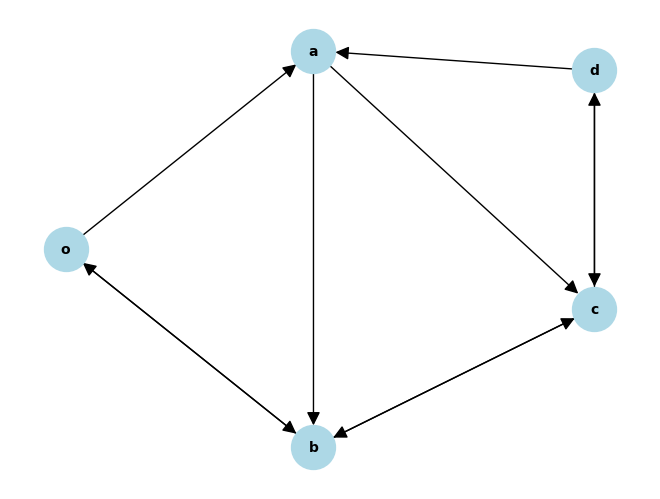

In [3]:
###############Graph Definition###############

nodes = ['o','a','b','c','d']
LAMBDA = [[0,2/5,1/5,0,0],
          [0,0,3/4,1/4,0],
          [1/2,0,0,1/3,0],
          [0,0,1/3,0,2/3],
          [0,1/3,0,1/3,0]]

edges = [   ('o','a', {'weight' : 2/5}),
            ('o','b', {'weight' : 1/5}),
            ('a','b', {'weight' : 3/4}),
            ('a','c', {'weight' : 1/4}),  
            ('b','o', {'weight' : 1/2}),
            ('b','c', {'weight' : 1/3}),
            ('c','b', {'weight' : 1/3}),
            ('c','d', {'weight' : 2/3}),
            ('d','a', {'weight' : 1/3}),
            ('d','c', {'weight' : 1/3})]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos_init = {
    'o': (-1.5,  0.0),
    'a': ( 0.0,  1.0),
    'b': ( 0.0, -1.0),
    'c': ( 1.7, -0.3),
    'd': ( 1.7,  0.9),
}

nx.draw(G, pos_init, with_labels=True, node_color='lightblue', node_size=1000, font_size=10, font_weight='bold', arrowsize=20)

plt.show()

**Simulation Setting**

Here I adopted one Poisson clock per node, each with rate $\omega_i$, so I'm using P matrix instead of P_bar. As assigment specify, we use draw t_next, time between two tics of poisson clocks with rate r, as uniform and computed withing logarithm. Here we have 1 rate for each node, so each node has rate r = $\lambda_i$, which is the sum over j of all $\lambda_{ij}$ . Also, according to laboratory, I will start from node o (similar to 0), so I'm going to do first simulation individually and then iterate on others.

To let simulation being easier to handle, I used a map in order to encode nodes in numerical values.

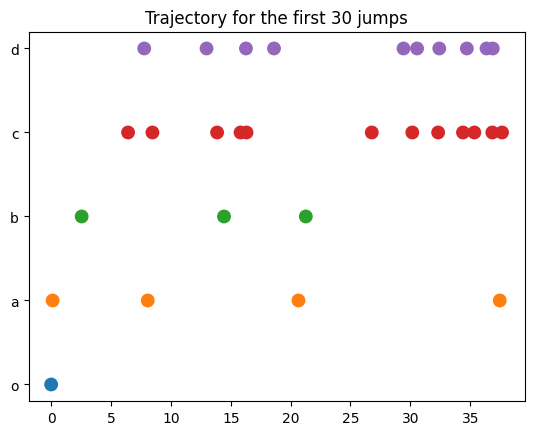

In [4]:
###############Simulation###############
w = np.sum(LAMBDA, axis=1)                     # Already real
D = np.diag(w)
P = np.linalg.inv(D) @ LAMBDA

map = { 0 : 'o',
        1 : 'a',
        2 : 'b',
        3 : 'c',
        4 : 'd'
    }

n_steps = 1000                                  # Len simulation
n_states = P.shape[1]                           # We know we have 5 states, just to let code be generic
pos = np.zeros(n_steps)                         # Memorizes trajectory, i.e. where simulation is at current time
pos[0] = 0                                      # We start from node o
transition_times = np.zeros(n_steps)            # Stores instants in which simulation jumps from a state to another

t_next = -np.log(np.random.rand())/w[0]         # Node o in in row 0 in Lambda matrix

for i in range(1,n_steps):
    pos[i] = choice(n_states,p=P[int(pos[i-1]),:])          # choise randomly where to go form previous state based on probabilities
    transition_times[i] = transition_times[i-1] + t_next    # store when will has been made jump
    t_next = -np.log(np.random.rand())/w[int(pos[i])]       # find new tic based on rate of clock current state (in which we just did jump)

state_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:green',
    3: 'tab:red',
    4: 'tab:purple'
}

colors = [state_colors[int(s)] for s in pos[:30]]

plt.scatter(transition_times[:30], pos[:30], c=colors, s=80)
plt.yticks([0,1,2,3,4], ['o','a','b','c','d'])
plt.title("Trajectory for the first 30 jumps")

plt.show()

**Estimate of Invariant Distribution**

When we estimate pi with one clock per state we have to undetstand how much chain spent time in a single state. Since transition times is a list of cumulative times, we have to subtract from next state the previous one as ("moment in which chain left state" - "moment in which chain entered in that state). Therefore, the usage of **append** into np.diif is due the fact that we have to understand when chain would leave last state of the simulation.

In [5]:
###############Pi Estimation###############
pi_bar = np.zeros(n_states)

intervals = np.diff(transition_times,n=1,append=(transition_times[-1] + t_next))
for node in range(n_states):
    visits = np.argwhere(pos==node)
    pi_bar[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)

print(f'Estimated pi_bar: {pi_bar}')

Estimated pi_bar: [0.18133517 0.15560101 0.28139697 0.19426015 0.1874067 ]


***(a) POINT***

To compute (estimate) expected return time I thought that we can take entries on pos list corresponding to 'a' and observe after how much time 'a' occures again.
Within this information we can take corresponding time in wich chain enters in two consecutive 'a', then if we subtract these values and we take the cumulative sum, then we can obtain the average expected return time by dividing to number of times we visited 'a'. 

In [6]:
idx_a = np.argwhere([el == 1 for el in pos])
times_a = transition_times[idx_a].flatten()
a_visits = len(times_a)

#print(times_a)

last = True if pos[-1] == 1 else False                  # Flag is True if last element of simulation is an a and we should sum an atrificial timestamp

if last:
    t_next_a = -np.log(np.random.rand())/w[1]           # 1 is mapping of 'a'
    intervals_a = np.diff(times_a,n=1,append=(times_a[-1] + t_next_a))
    #print(intervals_a)
else:
    intervals_a = np.diff(times_a,n=1)
    #print(intervals_a)

exp_avg_return_time_a = np.sum(intervals_a)/a_visits
print(f'Expected Return Time(a) = {exp_avg_return_time_a}')

Expected Return Time(a) = 6.556328352836885


***(b) POINT***

To compute theoretical return time, I just apply classical definition where S = {a}. In particular, I'm going to directly solve the system by using x_hat and P_hat, where P_hat is the P matrix from which we subtract rows and columns corresponding to a. Then we solve linear system since (I-P_hat) is invertible (because V\S has at least one link pointing to S). This is made accordly with lab and we retrieve expected hittimg times. Then apply definition and retrive expected return time. 

In [7]:
S = [1]
R = [node for node in range(n_states) if node not in S]
beta = 1/w[R]
m = len(R)

hat_P = P[np.ix_(R,R)]                                          # P restricted to R
hat_x = np.linalg.solve((np.identity(m) - hat_P),beta)

hittings_s = np.zeros(n_states)
for p,r in enumerate(R):
    hittings_s[r] = hat_x[p]

print(f'Theoretical hitting times to reach a: {hittings_s}')                 # As we know, hitting time of 'a' is 0

return_time_a = 1/w[1] + np.dot(P[1,:],hittings_s)                   # Definition

print(f'Theoretical return time of a: {return_time_a}')
print(f'Gap estimation = {abs(return_time_a - exp_avg_return_time_a)}')

Theoretical hitting times to reach a: [3.55555556 0.         5.66666667 5.83333333 4.41666667]
Theoretical return time of a: 6.708333333333333
Gap estimation = 0.15200498049644828


The gap between estimated expected return time and the analitically computation is of 0.398. I suppose this difference comes from the fact that we made 1000 steps of simulation and, probably, these values would converge at increasing number of iterations. Probably we can write that this is a Monte Carlo error.

***(c) POINT***
Practically is the same as point a, but we have to take the hitting time from state o to state d. I used same approach. Here still the problem that we have to alternate indexes of o and d, so we have to check if two consecutive o occure and, in these cases, ignore them. This is my idea, I'm not sure if it is ok, because I intepreted assignment in this way: "from o to d", so if o goes in another o before d, time is taken from first o. Here everything is more "manually", if you know methods to do it in more "automized" and cleaner way you're invited to change it.

However, in this case we cannot add an artificial inteval in the case in which last element of the trajectory is o, beacuse here we are measuring hitting time from o to d. Hence, unique option in my opinion is to **remove** last element on the trajectory if it is o.

In [8]:
merged_idx = []
for idx,el in enumerate(pos):
    if el == 0:
        if len(merged_idx) == 0:
            merged_idx.append(idx)
        else:
            if pos[merged_idx[-1]] == 0:
                continue                                        # If last element appended was 'o' we ignore it
            else:
                merged_idx.append(idx)
    elif el == 4 and len(merged_idx) != 0 and merged_idx[-1] == 0:                      # If 4 occures before o, skip it 
        merged_idx.append(idx)

times_od = transition_times[merged_idx]

if len(times_od) % 2 == 1:
    times_od = times_od[:-1]                                # Is a check if somehow a 0 stands on last position I cut it off (if odd a 0 stands at last)

intervals_od = times_od[1::2] - times_od[0::2]
exp_avg_hitting_time_od = intervals_od.mean()

print(f"Expected Hitting Time(d) from o = {exp_avg_hitting_time_od}")

Expected Hitting Time(d) from o = 7.774695507022099


***(d) POINT***
Again, I computed hitting time in d coming from o by solving linear system as above and I take just first element (wich is o).

In [9]:
d_S = [4]
d_R = [node for node in range(n_states) if node not in d_S]
d_beta = 1/w[d_R]
d_m = len(d_R)

hat_d_P = P[np.ix_(d_R,d_R)]
hat_d_x = np.linalg.solve((np.identity(d_m) - hat_d_P),d_beta)

d_hittings_s = np.zeros(n_states)
for p,r in enumerate(d_R):
    d_hittings_s[r] = hat_d_x[p]

o_hitting_d = d_hittings_s[0]

print(f'Theoretical hitting time to reach d from o: {o_hitting_d}')
print(f'Gap estimation = {abs(o_hitting_d - exp_avg_hitting_time_od)}')

Theoretical hitting time to reach d from o: 10.766666666666667
Gap estimation = 2.991971159644568


**I HAVE NO IDEA WHY THIS DISCREPANCE**, but the point I think that is concerning the fact that with 1000 iterations, Monte Carlo is largely biased between previous case beacuse looking only in o-d walk, number of samples to compute mean is largely less than number of samples of a (as before made for return time).

***(e) POINT***

Basically, interpretation changes as now the sum of lambdas over j, fixed i, is the total influence of nodes linked to i on i. Moreover, within this sum we can compute P matrix elementwhise as $P_{ij} = \frac{W_{ij}}{\omega_i}$, where $\omega_i = \sum_k{W_{ik}}$. So the $x_i(t+1)=\sum_j{P_{ij}x_j(t)}$ is a linear averaging dynamic, a convex combination as a linear system (written in vector form) acting a weighted mean, and average comes from P matrix, since it is stochastic.

Hence, starting from an initial point x(0), which in our case is a state, we want to study the **convergence behavior** within $x(t+1)= P^t x(0)$, when t tends to inf. Of course, our idea of convergence is related to reaching and equilibrium x_0. By definition, given a set in which x_0 is defined and a map bringing it to same set, if f(x_0) = x_0, then x_0 is an quilibrium, meaning that opinion will not change from now on. If the set $\Omega$ is a metric space (i..e a space in which properties of definition for a metric are given, e.g. symmetry) and function in continuos on it, then the limit of dynamic saw above will **surely** reach an equilibrium.  

Moreover, we know that invariant distribution satisfy $P^T {\pi} = {\pi}$, which means that invariant distribution is the right eigenvector of transposed P, associated with dominant eigenvalue 1 (PF Theorem). If we observe dynamic, we see that $x(t+1)=Px(t)=Px_o=x_o$, i.e. equilibrium is the right eigenvector of P. So we define **consensius** as $\alpha\boldsymbol{1}$ which satisfy $\boldsymbol{1}^T \pi = \boldsymbol{1}$.

Now, if graph has only one sink connected component, we can assert that invariant distribution is unique and teh only equilibria is the consensus vector, which means that $x_o = \alpha\boldsymbol{1}$ with t tending to inf, **independetly** from initial state x(0) yuo start from. Moreover, alpha can be computed as $\alpha = \pi^Tx(0) = \sum_k{\pi_k x_k(0)}$. In other words consensus is a convex combination of initial opinions, weighted by unique invariant distribution. Actually this is telling us a lot about **centrality** of the nodes: as higher is the centrality of a node and higher will be the influence of its initial opinion on the consensus reached by the network.

So now, let's reason on what required by point e. We want to undestand if FDG model, where $\Lambda$ matrix is now considered as weights matrix, is converging to consensus whatever is the choice of x(0). Hence we have to check two crucial conditions on our graph: 
- must be strongly connected (True)
- must be aperiodic (check it)

If these two hold, wee can say that FDG model on linear averagin dynamic $x(t) = P^tx(0)$ converges to $x(t) = \alpha\boldsymbol{1}$ as t tend to inf, $\alpha = \sum_k{\pi_k x_k(0)}$ for every i and $\pi = P^T \pi$ is the unique invariant distribution of transposed P.

To check periodicity I explot the definition of periodicity: the periodicity of a graph is the most common divisor of the lengths of all circuits strating from a node and finishing on it. Hence, I computed powers of W matrix as $(W^l)_{ij} = \sum_{l(\gamma)=\gamma}{w_{\gamma}}$ is giving the sum of weights of all walks of length l starting form i and ending up to j. 

So at each iteration I will check elements of powered P matrix and if an element on the diagonal is greater than 0, I will append it to a list of periods. Then i will compute GCD on it and so then globally: if it is 1, this would mean that graph(or chain) is aperiodic.

**Note** nx provides function to check aperiodicity, but we can also implement a function to do so.

In [11]:
aperiodic = nx.is_aperiodic(G)
print(aperiodic)

True


To simulate FDG model i opted for the double model such that we are able to reach arithmetical mean. Hence I initialized $z_i(0) = \frac{1}{w_i}$ and convergence is given by: $\alpha_z = \lim_{t \to + \infty} z_i(t) = \sum_i z_i(0) \frac{w_i}{w} = \sum_{i} \frac{1}{w} = \frac{1}{\overline{w}}$.
Therefore, if we combine them we have: $\frac{\lim_{t \to + \infty} y_i(t)}{\lim_{t \to + \infty} z_i(t)} = \frac{\alpha_y}{\alpha_z} = \frac{x}{\overline{w}} \cdot \overline{w} = x$.